# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

In [3]:
device_num = 3
torch.cuda.set_device(device_num)
torch.cuda.current_device()

3

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [4]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(45),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(244),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()]) 

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [8]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [9]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [10]:
import time

In [12]:
for device in ['cuda', 'cpu']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cuda; Time per batch: 0.011 seconds
Device = cpu; Time per batch: 5.570 seconds


In [13]:
torch.cuda.is_available()

True

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [148]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [8]:
## TODO: Use a pretrained model to classify the cat and dog images
# data
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

# loss
criterion = nn.NLLLoss()

# resnet / densnet
model_type = 'resnet'
#model_type = 'densenet'

# create model
if model_type == 'resnet':
    model = models.resnet50(pretrained=True)
    input_size = 2048
elif model_type == 'densenet':
    model = models.densenet121(pretrained=True)
    input_size = 1024
    
hidden_size = 512
    
# freeze model
for param in model.parameters():
    param.requires_grad = False


    
# redefine classifier layer (2 outputs) with some hidden FC layer
classif = nn.Sequential(OrderedDict([
                                    ('fc1', nn.Linear(input_size, 512)),
                                    ('relu1', nn.ReLU()),
                                    ('drop', nn.Dropout(0.2)),
                                    ('fc2', nn.Linear(512, 2)),
                                    ('out', nn.LogSoftmax(dim=1))
                                   ]))

if model_type == 'resnet':
    model.fc = classif
    optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
elif model_type == 'densenet':
    model.classifier = classif  # densenet
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

# use GPU
model.to('cuda')

print('model ready for finetuning!')

# train
epochs = 1
train_losses, test_losses, accuracies = [], [], []
print_every = 1
running_loss = 0

for e in range(epochs):
    running_loss = 0
    steps = 0
    model.train()
    
    print('\nepoch {}/{}'.format(e+1, epochs))
    for images, labels in trainloader:
        steps += 1
        images, labels = images.to('cuda'), labels.to('cuda')   # use GPU
        
        optimizer.zero_grad()               # reset gradients
        logits = model.forward(images)      # forward pass
        loss = criterion(logits, labels)    # compute loss
        loss.backward()                     # backprop        
        optimizer.step()                    # optimize
        running_loss += loss.item()         # update running loss
        
        if steps % print_every == 0:
            # validation
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in testloader:
                    # loss
                    images, labels = images.to('cuda'), labels.to('cuda')
                    logits = model.forward(images)
                    test_loss += criterion(logits, labels).item()

                    # accuracy
                    props = torch.exp(logits)
                    top_prop, top_class = props.topk(1, dim=1)
                    correct_classes = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(correct_classes.type(torch.FloatTensor)).item()
            
            model.train()
            
            # keep track
            tr_l = running_loss/print_every
            te_l = test_loss/len(testloader)
            acc = accuracy/len(testloader)
            train_losses.append(tr_l)
            test_losses.append(te_l)
            accuracies.append(acc)
            print('{}-{} train loss: {:.3f}  test loss: {:.3f}  accuracy: {:.3f}' \
                  .format(e+1, steps, tr_l, te_l, acc))
            running_loss = 0
        
    # keep track
    
        
#     # validation
#     test_loss = 0
#     accuracy = 0
#     model.eval()
#     with torch.no_grad():
#         for images, labels in testloader:
#             # loss
#             images, labels = images.to('cuda'), labels.to('cuda')
#             logits = model.forward(images)
#             test_loss += loss.item()
    
#             # accuracy
#             props = torch.exp(logits)
#             top_prop, top_class = props.topk(1, dim=1)
#             correct_classes = top_class == labels.view(*top_class.shape)
#             accuracy += torch.mean(correct_classes.type(torch.FloatTensor)).item()
        
    

model ready for finetuning!

epoch 1/1
1-1 train loss: 0.689  test loss: 0.486  accuracy: 0.756
1-2 train loss: 1.201  test loss: 5.786  accuracy: 0.488
1-3 train loss: 6.669  test loss: 2.940  accuracy: 0.488
1-4 train loss: 2.757  test loss: 0.176  accuracy: 0.944
1-5 train loss: 0.402  test loss: 0.953  accuracy: 0.548
1-6 train loss: 1.950  test loss: 0.610  accuracy: 0.691
1-7 train loss: 1.053  test loss: 0.162  accuracy: 0.952
1-8 train loss: 0.332  test loss: 0.556  accuracy: 0.711
1-9 train loss: 0.621  test loss: 0.723  accuracy: 0.629
1-10 train loss: 0.548  test loss: 0.488  accuracy: 0.748
1-11 train loss: 0.451  test loss: 0.221  accuracy: 0.909
1-12 train loss: 0.275  test loss: 0.152  accuracy: 0.947
1-13 train loss: 0.346  test loss: 0.177  accuracy: 0.929
1-14 train loss: 0.449  test loss: 0.162  accuracy: 0.941
1-15 train loss: 0.285  test loss: 0.148  accuracy: 0.946
1-16 train loss: 0.360  test loss: 0.194  accuracy: 0.923
1-17 train loss: 0.274  test loss: 0.328  

1-142 train loss: 0.234  test loss: 0.150  accuracy: 0.940
1-143 train loss: 0.205  test loss: 0.198  accuracy: 0.917
1-144 train loss: 0.134  test loss: 0.267  accuracy: 0.891
1-145 train loss: 0.164  test loss: 0.310  accuracy: 0.876
1-146 train loss: 0.161  test loss: 0.361  accuracy: 0.854
1-147 train loss: 0.206  test loss: 0.312  accuracy: 0.876
1-148 train loss: 0.082  test loss: 0.246  accuracy: 0.898
1-149 train loss: 0.121  test loss: 0.205  accuracy: 0.913
1-150 train loss: 0.196  test loss: 0.157  accuracy: 0.935
1-151 train loss: 0.180  test loss: 0.132  accuracy: 0.945
1-152 train loss: 0.227  test loss: 0.132  accuracy: 0.945
1-153 train loss: 0.140  test loss: 0.146  accuracy: 0.942
1-154 train loss: 0.119  test loss: 0.190  accuracy: 0.919
1-155 train loss: 0.117  test loss: 0.241  accuracy: 0.905
1-156 train loss: 0.099  test loss: 0.315  accuracy: 0.881
1-157 train loss: 0.127  test loss: 0.384  accuracy: 0.859
1-158 train loss: 0.081  test loss: 0.440  accuracy: 0.8

1-281 train loss: 0.230  test loss: 0.118  accuracy: 0.949
1-282 train loss: 0.203  test loss: 0.119  accuracy: 0.951
1-283 train loss: 0.202  test loss: 0.168  accuracy: 0.925
1-284 train loss: 0.160  test loss: 0.295  accuracy: 0.880
1-285 train loss: 0.126  test loss: 0.415  accuracy: 0.848
1-286 train loss: 0.173  test loss: 0.459  accuracy: 0.838
1-287 train loss: 0.304  test loss: 0.366  accuracy: 0.861
1-288 train loss: 0.139  test loss: 0.232  accuracy: 0.907
1-289 train loss: 0.100  test loss: 0.176  accuracy: 0.924
1-290 train loss: 0.087  test loss: 0.144  accuracy: 0.940
1-291 train loss: 0.178  test loss: 0.138  accuracy: 0.941
1-292 train loss: 0.276  test loss: 0.146  accuracy: 0.939
1-293 train loss: 0.132  test loss: 0.172  accuracy: 0.924
1-294 train loss: 0.158  test loss: 0.224  accuracy: 0.909
1-295 train loss: 0.093  test loss: 0.300  accuracy: 0.880
1-296 train loss: 0.076  test loss: 0.385  accuracy: 0.859
1-297 train loss: 0.467  test loss: 0.307  accuracy: 0.8

### resnet h=512, dr=0.2, every 1

In [9]:
results_h512_dr02_resnet = [train_losses, test_losses, accuracies]

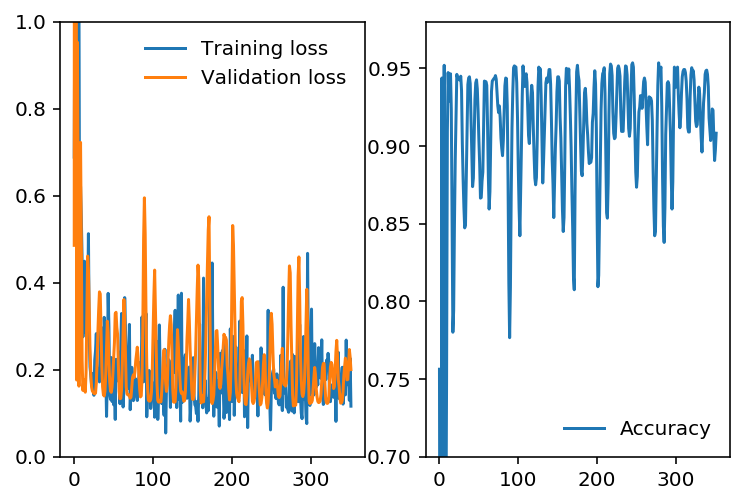

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

training_loss, validation_loss, accuracy = results_h512_dr02_resnet

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.ylim([0, 1])
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.ylim([0.7, 0.98])
plt.legend(frameon=False)

plt.show()

### resnet h=256, dr=0.2, every 2

In [153]:
results_h256_dr02_resnet = [train_losses, test_losses, accuracies]

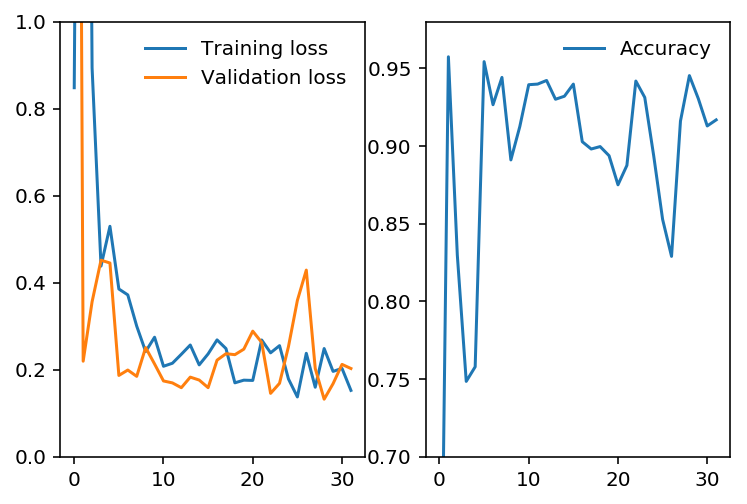

In [155]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

training_loss, validation_loss, accuracy = results_h256_dr02_resnet

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.ylim([0, 1])
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.ylim([0.7, 0.98])
plt.legend(frameon=False)

plt.show()

### h=256, dr=0.2, every 11

In [125]:
results_h256_dr02_gran11 = [train_losses, test_losses, accuracies]

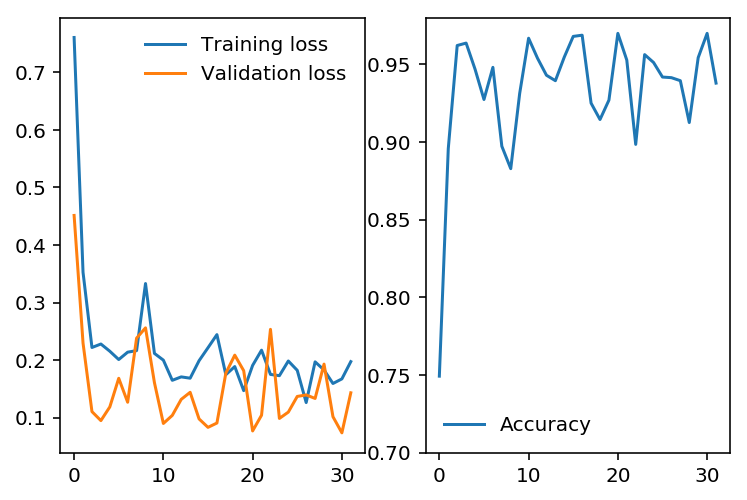

In [126]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

training_loss, validation_loss, accuracy = results_h256_dr02

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.ylim([0.7, 0.98])
plt.legend(frameon=False)

plt.show()

### h=256, dr=0.2, every 2

In [128]:
results_h256_dr02_gran2 = [train_losses, test_losses, accuracies]

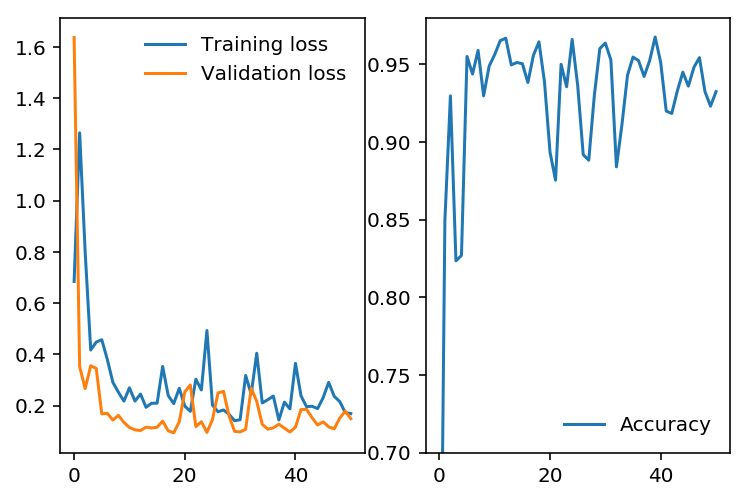

In [129]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

training_loss, validation_loss, accuracy = results_h256_dr02_gran2

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.ylim([0.7, 0.98])
plt.legend(frameon=False)

plt.show()

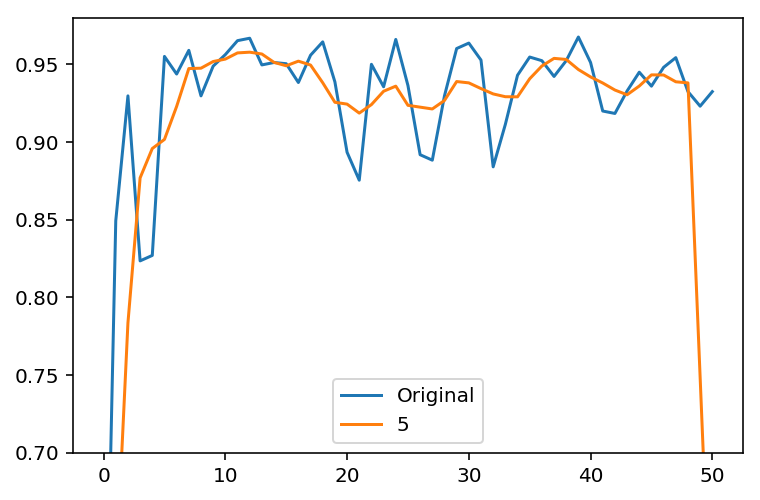

In [146]:
import numpy as np

# Create a figure canvas and plot the original, noisy data
fig, ax = plt.subplots()
ax.plot(accuracy, label="Original")
# Compute moving averages using different window sizes
window_lst = [5]
y_avg = np.zeros((len(window_lst) , len(accuracy)))
for i, window in enumerate(window_lst):
    avg_mask = np.ones(window) / window
    y_avg[i, :] = np.convolve(accuracy, avg_mask, 'same')
    # Plot each running average with an offset of .1
    # in order to be able to distinguish them
    ax.plot(y_avg[i, :] + (i), label=window)
# Add legend to plot

plt.ylim([0.7, 0.98])
ax.legend()
plt.show()

## Toying with class inheritance

In [55]:
models.densenet121??

In [73]:
torchvision.models.DenseNet??

In [106]:
import torchvision
import re

class Network(torchvision.models.DenseNet):
    
    def __init__(self, pretrained=False, finetune=False, device='cpu', **kwargs):
        
        super().__init__(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16),
                     **kwargs)
        
        import torch.utils.model_zoo as model_zoo
        from torchvision.models import DenseNet
        
        # load params from model zoo
        if pretrained:
            pattern = re.compile(
                r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
            model_url = 'https://download.pytorch.org/models/densenet121-a639ec97.pth'
            state_dict = model_zoo.load_url(model_url)
            for key in list(state_dict.keys()):
                res = pattern.match(key)
                if res:
                    new_key = res.group(1) + res.group(2)
                    state_dict[new_key] = state_dict[key]
                    del state_dict[key]
            self.load_state_dict(state_dict)
            
        # freeze params and redefine classifier
        if finetune:
            for param in model.parameters():
                param.requires_grad = False
            self.classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(1024, 256)),
                ('relu1', nn.ReLU()),
                ('drop', nn.Dropout()),
                ('fc2', nn.Linear(256, 2)),
                ('out', nn.LogSoftmax(dim=1))
                ]))

        self.to(device)
        
        return
        
    def score(self, train_loss, trainloader, testloader, criterion, optimizer):
        print('train loss', train_loss)
        
    
    def fit(self, trainloader, testloader, criterion, optimizer, epochs=5, print_every=4):

        for e in range(epochs):
            running_loss = 0
            steps = 0
            self.train() # training mode

            print('epoch {}/{}'.format(e+1, epochs))
            for images, labels in trainloader:
                steps += 1
                images, labels = images.to('cuda'), labels.to('cuda')
                optimizer.zero_grad()
                logits = self.forward(images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                if steps % print_every == 0:
                    train_loss = running_loss / steps
                    self.score(train_loss, trainloader, testloader, criterion, optimizer)

In [107]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

m = Network(pretrained=True, finetune=True, device='cuda')
m.fit(trainloader, testloader, criterion, optimizer)
m.score(0, trainloader, testloader, criterion, optimizer)

/mnt/home/laure/venvs/deep-learning/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


epoch 1/5
train loss 0.7010279446840286
train loss 0.7017491459846497
train loss 0.7014443327983221
train loss 0.7028365805745125
train loss 0.7026337832212448
train loss 0.7040900612870852


KeyboardInterrupt: 

In [85]:
m

Network(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace